# Búsqueda de Expedientes Médicos usando Latent Semantic Analysis (LSA)

In [ ]:
!pip3 install nltk

In [1]:
import pandas as pd
import numpy as np

from scipy.linalg import sqrtm

# Para preprocesar texto...
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

nltk.download('stopwords')
nltk.download('wordnet')  # WordNetLemmatizer

# Para construcción de bolsa de palabras ...
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrom2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pedrom2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

## Funciones auxiliares

In [3]:
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [4]:
def elimina_puntuacion(texto):
  nuevo_texto = re.sub('[^A-ZÜÖÄa-z]+', ' ', texto)  # Puntuación y todo lo que no sea letra ni números
  return nuevo_texto

In [5]:
lemmatizer = WordNetLemmatizer()

def lematizar(texto):
  texto=texto.split()
  nuevo_texto = " ".join([lemmatizer.lemmatize(i) for i in texto])
  return nuevo_texto

In [6]:
st = PorterStemmer()

def stemmer(texto):
  texto=texto.split()
  nuevo_texto =" ".join([st.stem(i) for i in texto])
  return nuevo_texto

In [7]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion(texto)
  texto = stemmer(texto)
  return(texto)

In [8]:
def vectorizar_consulta(texto):
  ''' Regresa la consulta vectorizada con el mismo vocabulario que el corpus,
  y pesos tfidf en relación al corpus '''
  q = preprocesar(texto)
  q = tfidf.transform([q])
  q = q.toarray()
  return q


In [9]:
def reducir_vec_consulta (q):
  q_k = (q @ np.transpose(Vt_k)) @ (D_k)
  return q_k

In [10]:
def descomposicion_k(U_k, D_k, Vt_k):
  ''' A partir de las tres matrices correspondientes a la  descomposición
  truncada en  valores singulares (donde k << r), devuelve dos matrices:
  la primera de tamaño n por k, y la segunda de dimensión k por d  '''
  MDT_n_k = np.matmul(U_k, sqrtm(D_k))
  MDT_k_d =  np.matmul(sqrtm(D_k), Vt_k)
  return MDT_n_k, MDT_k_d

In [11]:
def documentos_similares(q_vec, M, lim = 0):
  q_vec = q_vec.flatten()
  n = M.shape[0]
  sim_coseno = {}
  relevantes = {}
  # Calcular similitud coseno
  for i in range(n):
    sim_coseno[i] = np.dot(M[i,:], q_vec) / (np.linalg.norm(M[i,:]) * np.linalg.norm(q_vec))
    if sim_coseno[i] > lim:
      relevantes[i] = sim_coseno[i]
  if not relevantes:
    raise Exception( "No existen documentos similares", lim)

  # Ordenar valores
  relevantes_ordenados = {k:v for k, v in sorted(relevantes.items(),
                                                 key=lambda x: x[1],
                                                 reverse=True)}
  indices = list(relevantes_ordenados.keys())

  return corpus.loc[indices, :]

In [13]:
def precision_sensibilidad(q, M, limites):
  doc_sim_dic = {}
  precision_dic = {}
  sensibilidad_dic = {}
  tolerancias_dic = {}

  for tol in limites:
    tolerancias_dic[tol] = tol
    df_similares = documentos_similares(q, M, lim = tol)
    doc_sim_dic[tol] =df_similares
    Dt = len(df_similares)                       # Documentos encontrados
    Dr = (df_similares['label']==clase_q).sum()  # Documentos relevantes encontrados
    Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

    # Documentos relevantes encontrados, entre todos los doc encontrados similares
    precision_dic[tol] = Dr / Dt

    # Documentos relevantes encontrados, entre todos los documentos en el corpus
    sensibilidad_dic[tol] = Dr / Nr   # (Recall)

  evaluacion = pd.DataFrame({'precision': precision_dic,
                           'sensibilidad': sensibilidad_dic
                           })
  evaluacion.plot.line(x= 'sensibilidad', y= 'precision',
                       title ='Precisión vs Sensibilidad',
                       xlim=(0,1), ylim=(0,1))

  plt.grid(alpha=.8, linestyle='--')
  plt.show()
  return evaluacion

## Lectura de datos

El conjunto completo de datos se encuentra en [OHSUMED dataset](https://www.mat.unical.it/OlexSuite/Datasets/SampleDataSets-about.htm). El dataset que utilizaremos está un poco preprocesado para quedarnos con resumenes textuales de enfermedades que están catalogadas en **23 categorías.**

In [14]:
datos = pd.read_csv('./ohsumed_abstracts.csv',
                    usecols=[0,1,2], index_col = 0)

print(datos.shape)
datos.head()

(13924, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."


In [15]:
datos.loc[2,'doc']

' Childhood pulmonary function following hyaline membrane disease, Hyaline membrane disease per se is not associated with abnormal lung function or increased nonspecific airway reactivity in childhood or adulthood. Very-low-birth-weight infants who survive almost routinely in neonatal ICUs are at risk. however. for developing airflow obstruction and having airway hyperreactivity as children. and for having recurrent bouts of wheezing. cough. and respiratory infections. Neonates who develop BPD have the greatest risk of abnormal pulmonary function as children. Continued research into the prevention of premature birth and into the causes of neonatal lung injury. combined with improvements in the neonatal ICU and follow-up treatment. will undoubtedly contribute to improvement in the clinical course of premature infants.'

In [16]:
datos.loc[1,'doc']

' Chylothorax after posterior spinal instrumentation and fusion, Chylothorax occurred in a 16-year-old girl after posterior spinal fusion and instrumentation for idiopathic scoliosis. Nonoperative management. including chest tube drainage for 26 days and total parenteral nutrition. successfully treated this unusual complication after a posterior spinal fusion.'

In [17]:
len(datos['label'].value_counts())

23

Los documentos están catalogados en **23 categorías**.

In [18]:
datos.sample(10, random_state=3)

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [19]:
# Separamos una muestra aleatoria de 10 documentos, que serán nuestras consultas
consultas_idx = datos.sample(10, random_state=3).index
consultas = datos.iloc[consultas_idx,:].copy()
consultas

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [20]:
# Dejamos el resto de documentos como nuestro corpus
corpus = pd.concat([datos,consultas]).drop_duplicates(keep=False).reset_index(drop=True)
consultas = consultas.reset_index(drop=True)
print(corpus.shape)
corpus

(13914, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."
...,...,...
13909,11,Results of blepharoptosis surgery with early ...
13910,11,"A century of cerebral achromatopsia, This rev..."
13911,11,Intraocular lens implantation after penetrati...
13912,11,Reproducibility of topographic measurements o...


In [21]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


## Preprocesamiento de texto

In [22]:
ejemplo = np.random.choice(corpus['doc'])
print(len(ejemplo))
ejemplo

1244


' Prolonged continuous acyclovir treatment of normal adults with frequently recurring genital herpes simplex virus infection. The Acyclovir Study Group, In this 3-year study of suppressive acyclovir for recurrent genital herpes. patients with more than six recurrences per year were randomized initially to 400 mg of acyclovir or placebo orally two times per day. with recurrences treated with 200 mg of acyclovir five times per day for 5 days. In the second year of the study. all patients received acyclovir as a daily suppressive or intermittent acute therapy; in the third year. all received daily acyclovir. Among 525 patients completing 3 study years. 289 received 3 years of suppressive therapy and 236 received 1 year of acute therapy followed by 2 years of suppressive therapy. Of those who completed the third year. 61% were recurrence free that year; 25% of the suppressive therapy-only group were recurrence free for all 3 years. The annual recurrence rate dropped from more than 12 recur

**Transformarmos el texto a minúsculas...**

In [23]:
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo

1244


' prolonged continuous acyclovir treatment of normal adults with frequently recurring genital herpes simplex virus infection. the acyclovir study group, in this 3-year study of suppressive acyclovir for recurrent genital herpes. patients with more than six recurrences per year were randomized initially to 400 mg of acyclovir or placebo orally two times per day. with recurrences treated with 200 mg of acyclovir five times per day for 5 days. in the second year of the study. all patients received acyclovir as a daily suppressive or intermittent acute therapy; in the third year. all received daily acyclovir. among 525 patients completing 3 study years. 289 received 3 years of suppressive therapy and 236 received 1 year of acute therapy followed by 2 years of suppressive therapy. of those who completed the third year. 61% were recurrence free that year; 25% of the suppressive therapy-only group were recurrence free for all 3 years. the annual recurrence rate dropped from more than 12 recur

**Quitamos puntuación...**

In [24]:
ejemplo = elimina_puntuacion(ejemplo)
print(len(ejemplo))
ejemplo

1171


' prolonged continuous acyclovir treatment of normal adults with frequently recurring genital herpes simplex virus infection the acyclovir study group in this year study of suppressive acyclovir for recurrent genital herpes patients with more than six recurrences per year were randomized initially to mg of acyclovir or placebo orally two times per day with recurrences treated with mg of acyclovir five times per day for days in the second year of the study all patients received acyclovir as a daily suppressive or intermittent acute therapy in the third year all received daily acyclovir among patients completing study years received years of suppressive therapy and received year of acute therapy followed by years of suppressive therapy of those who completed the third year were recurrence free that year of the suppressive therapy only group were recurrence free for all years the annual recurrence rate dropped from more than recurrences per year at baseline to suppressive therapy and acut

**Quitamos palabras irrelevantes (_stopwords_)...**

In [25]:
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

933


' prolonged continuous acyclovir treatment normal adults frequently recurring genital herpes simplex virus infection acyclovir study group year study suppressive acyclovir recurrent genital herpes patients six recurrences per year randomized initially mg acyclovir placebo orally two times per day recurrences treated mg acyclovir five times per day days second year study patients received acyclovir daily suppressive intermittent acute therapy third year received daily acyclovir among patients completing study years received years suppressive therapy received year acute therapy followed years suppressive therapy completed third year recurrence free year suppressive therapy group recurrence free years annual recurrence rate dropped recurrences per year baseline suppressive therapy acute suppressive therapy recurrences third year significant toxic effects detected daily suppressive acyclovir therapy effective well tolerated '

**Normalización del texto...**

Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la conversión de palabras en sus raíces.

In [26]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/pedrom2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
# Ejemplo de diferencia entre lematización y stemización (radicalización)
oracion = 'i have one foot and two feet constitutional'
print(lematizar(oracion)) # lemmatization uses a dictionary and morphological analysis
print(stemmer(oracion)) # stemming chops via heuristic, which can result in non-dictionary words

i have one foot and two foot constitutional
i have one foot and two feet constitut


In [29]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo_lema))
ejemplo_lema

915


'prolonged continuous acyclovir treatment normal adult frequently recurring genital herpes simplex virus infection acyclovir study group year study suppressive acyclovir recurrent genital herpes patient six recurrence per year randomized initially mg acyclovir placebo orally two time per day recurrence treated mg acyclovir five time per day day second year study patient received acyclovir daily suppressive intermittent acute therapy third year received daily acyclovir among patient completing study year received year suppressive therapy received year acute therapy followed year suppressive therapy completed third year recurrence free year suppressive therapy group recurrence free year annual recurrence rate dropped recurrence per year baseline suppressive therapy acute suppressive therapy recurrence third year significant toxic effect detected daily suppressive acyclovir therapy effective well tolerated'

In [30]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo_stem))
ejemplo_stem

788


'prolong continu acyclovir treatment normal adult frequent recur genit herp simplex viru infect acyclovir studi group year studi suppress acyclovir recurr genit herp patient six recurr per year random initi mg acyclovir placebo oral two time per day recurr treat mg acyclovir five time per day day second year studi patient receiv acyclovir daili suppress intermitt acut therapi third year receiv daili acyclovir among patient complet studi year receiv year suppress therapi receiv year acut therapi follow year suppress therapi complet third year recurr free year suppress therapi group recurr free year annual recurr rate drop recurr per year baselin suppress therapi acut suppress therapi recurr third year signific toxic effect detect daili suppress acyclovir therapi effect well toler'

Juntamos todos estos pasos en la función auxiliar preprocesar.

In [31]:
%%time
corpus['doc_pp'] = corpus['doc'].apply(preprocesar)

CPU times: user 20 s, sys: 323 ms, total: 20.3 s
Wall time: 20.4 s


In [32]:
corpus.head()

,label,doc,doc_pp
0,16,Improved outcome at 28 days of age for very l...,improv outcom day age low birth weight infant ...
1,5,Chylothorax after posterior spinal instrument...,chylothorax posterior spinal instrument fusion...
2,16,Childhood pulmonary function following hyalin...,childhood pulmonari function follow hyalin mem...
3,8,Treatment of atelectasis of upper lung lobes....,treatment atelectasi upper lung lobe select br...
4,21,"Decision analysis, public health policy, and ...",decis analysi public health polici isoniazid c...


## Vectorización vía TF-IDF con scikit-learn

Usaremos la funcion **```TFidfVectorizer```** de sklearn.
Notar que el paramentro **```min_df```** hace la función "cut-off" para no considerar los términos con poca frecuencia en el documento.
En este ejercio se ha establecido una frecuencia de al menos 70 documentos que contengan el término que corresponde a cerca del 0.5% de todos los documentos


In [33]:
tfidf = TfidfVectorizer(min_df=30)
mdt_tfidf = tfidf.fit_transform(corpus['doc_pp'])
palabras = tfidf.get_feature_names_out()
MDT = pd.DataFrame(mdt_tfidf.todense(),
                              index=corpus.index,
                              columns=palabras)
print(MDT.shape)
MDT

(13914, 3408)


,ab,abdomen,abdomin,aberr,abil,abl,ablat,abnorm,abolish,abort,...,year,yet,yield,york,young,younger,yr,zero,zidovudin,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.068062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14475,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.041414,0.0,0.0,0.0,0.079649,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [34]:
# ¿ Qué porcentaje de celdas tienen cero?

no_ceros = MDT.astype(bool).sum().sum()  # Cantidad de ceros en todo el dataframe
total = MDT.shape[0] * MDT.shape[1]

(1 - no_ceros/total) * 100

98.26726307005947

## Descomposición en valores singulares (SVD) con numpy

$~~ M = U~D~V^{T}$

$~~ M =
\sum_{i=1}^{min(m, n)}s_{i}\cdot u_{i}v_{i}^{T}
$






In [35]:
%%time
# Vemos las dimensiones de las tres matrices
# Descomposición Matriz Documento Término  (3 min)
U_, sigma_, Vt_ = np.linalg.svd(MDT)

# Obtener con los valores singulares (sigma) la matriz D
D_ = np.diag(sigma_)

print(U_.shape, D_.shape, Vt_.shape)

(13914, 13914) (3408, 3408) (3408, 3408)
CPU times: user 7min 7s, sys: 7.11 s, total: 7min 14s
Wall time: 1min 1s


In [36]:
D_

array([[2.05133821e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.08698582e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00211141e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.50061123e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.30627431e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.81904737e-15]])

In [37]:
sigma_.shape

(3408,)

In [38]:
# ¿Cuántos valores de sigma son distintos de cero?
sigmas = sigma_[np.nonzero(sigma_)]
len(sigmas)

3408

In [39]:
print(min(sigma_))

2.819047372744054e-15


In [40]:
# En el vector sigma estan ordenados los eigenvalores
sigma_

array([2.05133821e+01, 1.08698582e+01, 1.00211141e+01, ...,
       3.50061123e-01, 3.30627431e-01, 2.81904737e-15])

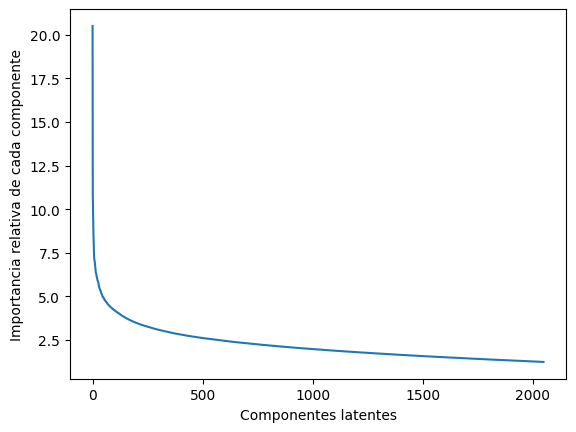

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 2049
sns.lineplot(x=list(range(len(sigma_[0:k]))), y = sigma_[0:k])
plt.ylabel('Importancia relativa de cada componente')
plt.xlabel('Componentes latentes')
plt.show()

## Análisis Semántico Latente
 SVD especificando $k<r$ con scipy


$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\hat{M} = U_{k}~~D_{k}~~V_{k}^{T}
$

In [42]:
%%time
from scipy.sparse.linalg import svds
U_k, sigmas_k, Vt_k = svds(np.array(MDT), k=100)
D_k = np.diag(sigmas_k)

CPU times: user 3min 47s, sys: 5.16 s, total: 3min 52s
Wall time: 31.3 s


In [43]:
# docs-temas / relevancia temas / temas-palabras

U_k.shape, D_k.shape, Vt_k.shape

((13914, 100), (100, 100), (100, 3408))


### Obtener la matriz reducida que representa a cada documento con k términos

$ M_{n\times{k}} = U_{k}~~\sqrt{D_{k}} $

In [44]:
M1 = np.matmul(U_k, sqrtm(D_k))
M1.shape

(13914, 100)

### Obtener la matriz reducida que representa a cada palabra con k términos
$ M_{k\times{d}} = \sqrt{D_{k}}~~{V_{k}}^T~~ $

In [45]:
M2 =  np.matmul(sqrtm(D_k), Vt_k)
M2.shape

(100, 3408)

Por facilidad la función auxiliar **```descomposicion_k()```** regresa las dos matrices obtenidas en las líneas anteriores



In [46]:
MDT_nk, MDT_kd = descomposicion_k(U_k, D_k, Vt_k )

print(MDT_nk.shape, MDT_kd.shape)

(13914, 100) (100, 3408)


In [47]:
# Dimensiones de las matrices reducidas
(M1).shape, np.transpose(M2).shape

((13914, 100), (3408, 100))

## Vectorización de consultas


Debemos ahora vectorizar nuestra consulta utilizando el mismo vocabulario que el corpus

In [48]:
# Podemos usar cualquier texto
q = vectorizar_consulta('heart disease')
q.shape

(1, 3408)

In [49]:
q

array([[0., 0., 0., ..., 0., 0., 0.]])

Como vemos, tenemos ahora la consulta con las d dimensiones que corresponden al vocabulario del corpus.



In [50]:
D_k

array([[ 4.21313102,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  4.21878693,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  4.22660336, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 10.02111407,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.86985825,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 20.51338214]])

**Ahora es necesario reducir el vector, usando nuestras matrices**

$\hat{q} =
q~V_{k}~D
$

In [51]:
q_k = (q @ np.transpose(Vt_k)) @ (D_k)
print(q.shape, np.transpose(Vt_k).shape, D_k.shape )
print(q_k.shape)

(1, 3408) (3408, 100) (100, 100)
(1, 100)


In [52]:
q_k

array([[ 3.04830233e-01,  2.13989021e-01, -8.13034574e-02,
        -1.26587223e-01, -2.14646564e-01, -7.52801044e-03,
         1.79490149e-01, -9.27830213e-02, -3.76554463e-01,
         2.41269673e-01,  2.65420696e-01,  2.93325628e-02,
        -1.51069829e-01, -3.05375711e-01,  1.56509876e-01,
        -3.00059686e-01, -2.05583298e-02,  3.21530427e-01,
         2.29464970e-01,  1.97999837e-01,  6.96176514e-02,
        -4.14270889e-01,  3.85368158e-01,  3.69601862e-02,
        -1.90744690e-01,  1.06927357e-02,  3.18735646e-01,
        -4.71419952e-01, -1.24391937e-01, -7.96706592e-02,
        -8.25847589e-02,  1.89774174e-01,  3.62993451e-01,
        -2.36311639e-01,  4.65896411e-01,  1.70952318e-02,
         4.51143977e-01,  2.45309993e-01, -1.36223856e-01,
         1.63096961e-02,  1.63143048e-01,  2.11891443e-02,
        -9.66609750e-02,  4.32360571e-01,  7.36401384e-01,
         4.58657210e-01,  4.90787407e-01, -3.14605053e-01,
         2.60866654e-01,  1.51826569e-01,  3.15330337e-0

Por facilidad guardamos el código anterior en la función auxiliar **```reducir_vec_consulta()```**



In [53]:
q_k = reducir_vec_consulta(q)
q_k.shape

(1, 100)

In [54]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [55]:
# Elegimos uno de los diagnósticos como consulta,
# guardamos la clase y el texto
q_idx = 1
clase_q =consultas.loc[q_idx,'label']
Q = consultas.loc[q_idx,'doc']

print('Clase de la consulta:' , clase_q,'\n')
Q

Clase de la consulta: 10 



' The community hospital-based stroke programs in North Carolina, Oregon and New York--V. Stroke diagnosis: factors influencing the diagnostic evaluation of patients following acute stroke, Among the 4129 patients of the Community Hospital-based Stroke Program. 30% had an unspecified stroke diagnosis. Since specific diagnosis and. perhaps. eventual treatment. derives in part from diagnostic testing. we examined the effect of clinical condition. geographic and demographic factors on the incidence of certain diagnostic tests after acute stroke. In this multivariable analysis. race. sex. history of hypertension and history of diabetes did not influence the chance of having any test. but older age strongly reduced the chances of receiving extensive evaluation. When CT scanning was available. the utilization of a CT as well as other diagnostic studies including cerebral angiography. radionuclide brain scan. EEG and EKG was increased. The odds of receiving a CT scan increased if the patient 

In [56]:
q = vectorizar_consulta(Q)  # Preprocesamos y vectorizamos
q_k = reducir_vec_consulta(q)  # Reducimos a k dimensiones
print ('Dimensión vector q  :', q.shape)
print ('Dimensión vector q_k:', q_k.shape)

Dimensión vector q  : (1, 3408)
Dimensión vector q_k: (1, 100)


## Búsqueda de documentos relevantes a la consulta

In [57]:
tol = .2  # Valor a partir del que se considera un doc similar a la consulta, el limite o threshold

doc_sim = documentos_similares(q_k, MDT_nk, lim = tol)


Dt = len(doc_sim)                       # Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  # Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

# Documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt

# Documentos relevantes encontrados, entre todos los doc relevantes en el corpus
sensibilidad = Dr / Nr   # Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  4798
      Documentos relevantes encontrados:  703
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.15
                           Sensibilidad: 0.58


In [58]:
tol = .2  # Valor a partir del que se considera un doc similar a la consulta

doc_sim = documentos_similares(q, MDT.to_numpy(), lim = tol)


Dt = len(doc_sim)                       # Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  # Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

# Documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt

# Documentos relevantes encontrados, entre todos los docrelevantes en el corpus
sensibilidad = Dr / Nr   # Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  43
      Documentos relevantes encontrados:  30
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.70
                           Sensibilidad: 0.02


## Evaluación de la recuperación de información

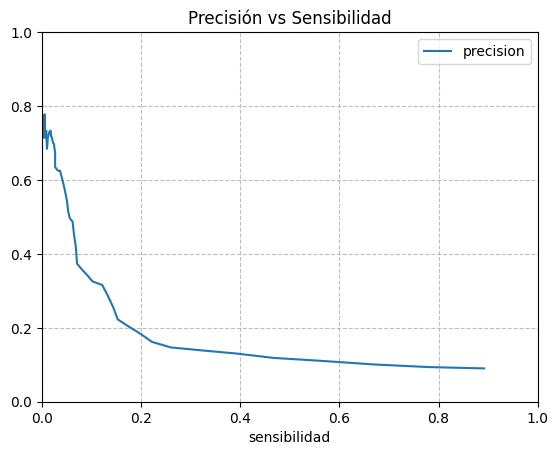

In [59]:
tols = np.linspace(0.01, 0.3, 50)
evaluacion = precision_sensibilidad(q, MDT.to_numpy(),tols)

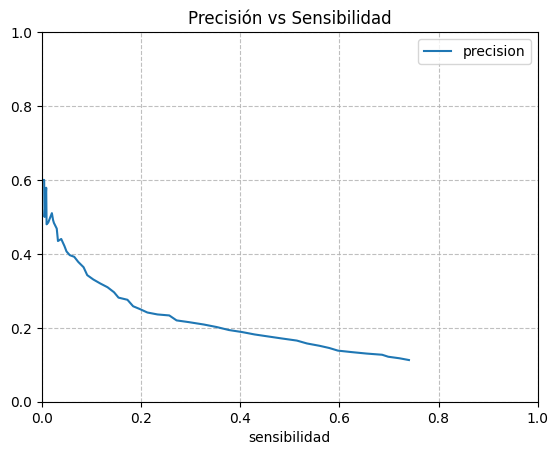

In [60]:
tols = np.linspace(0.15, 0.49, 50)
evaluacion_k = precision_sensibilidad(q_k, MDT_nk, tols)

In [61]:
eval = pd.merge(evaluacion_k, evaluacion, how='left', on= evaluacion.index, suffixes  = ('_k',''))
eval

,key_0,precision_k,sensibilidad_k,precision,sensibilidad
0,0.010000,0.112746,0.740377,0.090142,0.891892
1,0.015918,0.117498,0.721540,0.093744,0.780508
2,0.021837,0.121718,0.698608,0.100575,0.673219
3,0.027755,0.127085,0.686323,0.109920,0.570844
4,0.033673,0.130272,0.655201,0.118651,0.466830
5,0.039592,0.134236,0.624898,0.130613,0.390663
6,0.045510,0.138278,0.597052,0.139377,0.318591
7,0.051429,0.145320,0.579853,0.146882,0.260442
8,0.057347,0.151294,0.560197,0.161984,0.221949
9,0.063265,0.157615,0.534808,0.183183,0.199836


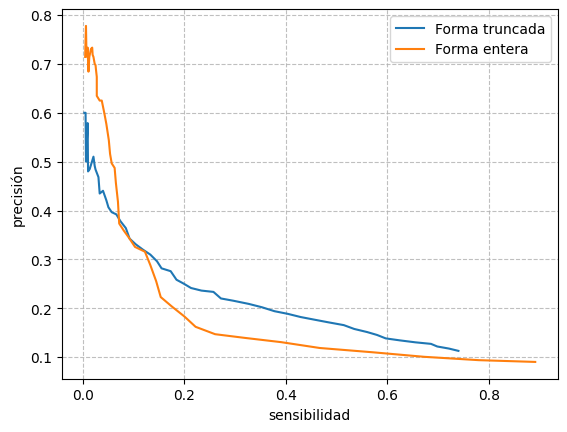

In [62]:
figsize =(4,4)
plt.plot(eval['sensibilidad_k'], eval['precision_k'], label='Forma truncada')
plt.plot(eval['sensibilidad'],  eval['precision'], label='Forma entera')

plt.xlim=(.15,1)
plt.xlabel('sensibilidad')
plt.ylabel('precisión')

plt.legend()
plt.grid(alpha=.8, linestyle='--')
plt.show()